In [ ]:
%load_ext autoreload
%autoreload 2
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import hist
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import sys
import os
sys.path.append("..")
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from hists.dataframe import DataframeComputations
from utils import makeDashLink, makeCsvRow, printCsvRowsFromDf
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.store import HistogramId

from event_visualizer.event_index import EventLoader, EventID
from event_visualizer.plotter.clue3D import Clue3DVisualization

from ratios_utils import makeFrequencyPerBeamEnergy, plotFrequencyPerBeamEnergy

In [4]:
def filterSpanEnergy(df:pd.DataFrame, minLayerSpan=5, minFractionOfBeamEnergy=0.2) -> pd.DataFrame:
    """ Filter 3D clusters to keep :
     - min layer span of 3D clusters
     - min fraction of beam energy of 3D clusters (incl synchrotron losses) 
    Then keep only the two highest energy 3D cluster per event (dropping events where only one 3D cluster passes selections)
    Returns dataframe with clus2D_minLayer	clus2D_maxLayer	beamEnergy	clus3D_energy	clus3D_size	clus3D_layerSpan
    Parameter : df : a dataframe holding beamEnergy, clus3D_energy, clus2D_minLayer, clus2D_maxLayer
    """
    return (df
    .eval("clus3D_layerSpan = clus2D_maxLayer - clus2D_minLayer")
    .query("clus3D_layerSpan >= @minLayerSpan")
    .sort_values(["event","clus3D_energy"])
    .groupby(["eventInternal"]).tail(2) # take the two trackster with max energy in each event
    # Filter events where only one trackster passes selections + filter on beam energy fraction
    .groupby("eventInternal").filter(lambda x : (len(x)>1 and x.clus3D_energy.min() > minFractionOfBeamEnergy*synchrotronBeamEnergiesMap[x.beamEnergy.iloc[0]]))
    .sort_values(["eventInternal", "clus2D_minLayer"])
    )

In [5]:
def unstackDataframe(df:pd.DataFrame):
    """ Unstack the 3D clusters into columns
    Retuyrns a dataframe with multiindex columns, where second layer is 
     - 0 for trackster with smallest first layer
     - 1 for the other trackster
    """
    df_unstacked = (df.assign(clus3D_number=df.groupby("eventInternal").cumcount())
        .reset_index("clus3D_id")
        .set_index("clus3D_number", append=True)
        .unstack()
    )
    #new_df = df_unstacked[["clus3D_id", "clus3D_energy", "clus2D_minLayer", "clus2D_maxLayer", "clus3D_layerSpan"]]
    return df_unstacked

In [6]:
def splitTracksterSelections(df:pd.DataFrame, maxLayerOverlap=2):
    """ Select events where the two tracksters overlap for at most maxLayerOverlap layers """
    return df.loc[df.clus2D_maxLayer[0] - df.clus2D_minLayer[1] < maxLayerOverlap]

In [7]:
def findSplitTracksters(tree, *, minLayerSpan=5, minFractionOfBeamEnergy=0.2, maxLayerOverlap=2):
    """ """
    selected_df = []
    total_events = 0
    for array in tree.iterate(step_size="10MB", library="ak", #entry_stop=10000,
            filter_name=["event", "ntupleNumber", "beamEnergy", "clus3D_energy", "clus3D_size", "clus3D_idxs", "clus2D_layer"], 
            ):
        total_events += len(array)
        comp = DataframeComputations(array)
        selected_df.append(comp
            .clusters3D_merged_2D_custom(comp.clusters3D_with_clus2D_id(["ntupleNumber", "event"]), comp.clusters2D_custom(["clus2D_layer"]))
            .pipe(comp.clusters3D_firstLastLayer, columnsToKeep=["beamEnergy", "ntupleNumber", "event", "clus3D_energy"])

            .pipe(filterSpanEnergy, minLayerSpan=minLayerSpan, minFractionOfBeamEnergy=minFractionOfBeamEnergy)
            .pipe(unstackDataframe)
            .pipe(splitTracksterSelections, maxLayerOverlap=maxLayerOverlap)
        )
    return pd.concat(selected_df), total_events

def printSplitTracksters(df:pd.DataFrame):
    new_df = df[["beamEnergy", "ntupleNumber", "event"]].loc[:, (slice(None),0)]
    new_df.columns = new_df.columns.droplevel(1) # remove the extra multiindex column level
    printCsvRowsFromDf(new_df, source="SplitTrackster")

In [8]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v37'
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
datatypes = ["data", "sim_proton_v46_patchMIP"]
tree = uproot.open('/data_cms_upgrade/cuisset/testbeam18/clue3d/v31/cmssw/data/CLUE_clusters.root:clusters')

In [9]:
def loadDatatype(datatype, settings):
    path = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root:clusters")
    tree = uproot.open(path)
    return findSplitTracksters(tree, **settings)

def loadForSettings(settings):
    return {datatype : loadDatatype(datatype, settings)[0] for datatype in datatypes}
def loadListOfSettings(settings_list):
    return {frozenset(setting.items()) : loadForSettings(setting) for setting in settings_list}

In [21]:
allResults = loadListOfSettings([dict(minLayerSpan=3, minFractionOfBeamEnergy=0.1, maxLayerOverlap=2)])

In [11]:
allResults[frozenset(dict(minLayerSpan=3, minFractionOfBeamEnergy=0.1, maxLayerOverlap=2).items())]["data"]

clus3D_id    beamEnergy        ntupleNumber      event         
clus3D_number         0  1          0      1            0    1     0     1   
eventInternal                                                                
661                   0  1      300.0  300.0          435  435  2015  2015  \
2469                  0  1      300.0  300.0          435  435  5559  5559   
2726                  0  1      300.0  300.0          435  435  8222  8222   
3002                  0  1      300.0  300.0          435  435  8406  8406   
3506                  0  1      300.0  300.0          435  435  1049  1049   
...                 ... ..        ...    ...          ...  ...   ...   ...   
40197                 0  1      200.0  200.0          676  676  2914  2914   
40262                 0  1      200.0  200.0          676  676  1785  1785   
40330                 0  1      200.0  200.0          676  676  2193  2193   
40331                 0  1      200.0  200.0          676  676  2200  2200   
41370                 0  1      200.0  200.0          676  676   640   640   

              clus3D_energy             clus2D_minLayer     clus2D_maxLayer   
clus3D_number             0           1               0   1               0   
eventInternal                                                                 
661               78.150787  207.632950               1  10               9  \
2469             192.563477   83.391350               1  19              18   
2726             141.080643  132.169449               1  16              15   
3002             213.655060   66.128052               1  19              20   
3506             197.005035   79.317070               1  17              16   
...                     ...         ...             ...  ..             ...   
40197             52.094963  144.193497               1   8               9   
40262            147.723724   24.850403               1  20              21   
40330             99.620811   91.251411               1  15              14   
40331             78.055428  106.587708               1  10               9   
41370             83.511780   94.342056               1  14              13   

                  clus3D_layerSpan      
clus3D_number   1                0   1  
eventInternal                           
661            28                8  18  
2469           28               17   9  
2726           28               14  12  
3002           28               19   9  
3506           28               15  11  
...            ..              ...  ..  
40197          28                8  20  
40262          28               20   8  
40330          28               13  13  
40331          28                8  18  
41370          28               12  14  

[1704 rows x 16 columns]

In [12]:
#printSplitTracksters(splitTrackster_df)

NameError: name 'splitTrackster_df' is not defined

In [34]:
def plot(series_dict:dict[str, pd.Series], settings:dict, ax=None, alternative_hypothesis="two-sided"):
    """ 
    Parameters : 
     - series : datatype -> series of beam energies
     - alternative_hypothesis : two-sided or greater 
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    errorbar_kwargs = dict()
    if alternative_hypothesis == "greater":
        errorbar_kwargs["lolims"] = True

    offset_x = 3
    cur_offset = 0
    for datatype, series in series_dict.items():
        ratio_val, ratio_errors = makeFrequencyPerBeamEnergy(series, datatype)
        ax.errorbar(x=np.array(beamEnergies)+cur_offset, y=ratio_val, yerr=ratio_errors, fmt="o-", #ecolor="black", 
                     label=datatypeToLegendMap[datatype], **errorbar_kwargs)
        cur_offset += offset_x

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fraction of split tracksters events")
    hep.cms.text("Preliminary", ax=ax)
    hep.cms.lumitext(f"minLayerSpan={settings['minLayerSpan']}, minFracBeamEnergy={settings['minFractionOfBeamEnergy']:.0%}"
                     f"\nmaxLayerOverlap={settings['maxLayerOverlap']}   $e^+$ TB", ax=ax,
        fontsize=15)
    ax.legend()
    #return ratio_val, ratio_errors

def makePlot(settings, datatypes, **kwargs):
    if not isinstance(datatypes, list):
        datatypes = [datatypes]
    plot({datatype : allResults[frozenset(settings.items())][datatype].beamEnergy[0] for datatype in datatypes}, settings, **kwargs)
    

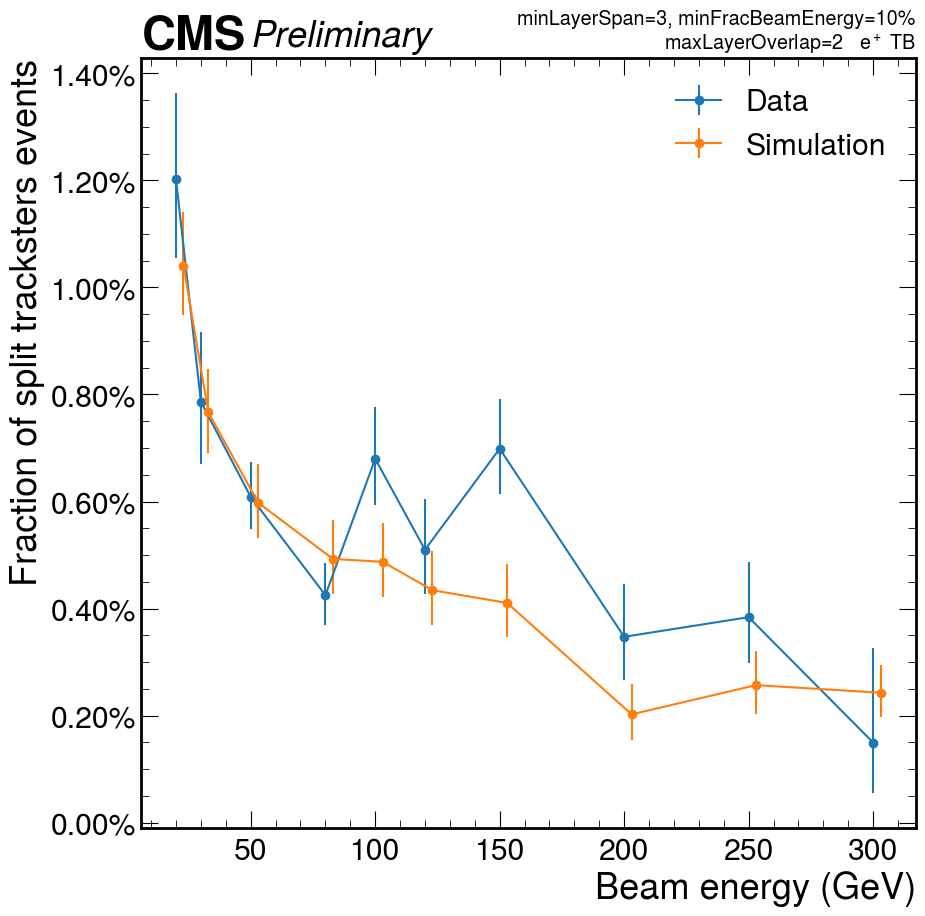

In [35]:
makePlot(dict(minLayerSpan=3, minFractionOfBeamEnergy=0.1, maxLayerOverlap=2), ["data", "sim_proton_v46_patchMIP"], alternative_hypothesis="two-sided")

In [ ]:
#sc = SampleChooser(pd.DataFrame.from_dict(dict(beamEnergy=splitTrackster_df.beamEnergy[0], ntupleNumber=splitTrackster_df.ntupleNumber[0], event=splitTrackster_df.event[0])))